In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
import cv2
import math
from math import ceil
import numpy as np
import pandas as pd
import random
import os
import glob
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from tqdm import tqdm
import ast
import sklearn as sk
from keras import Model
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from joblib import dump
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import zipfile
import random

# Loading of images and metadata:

In [96]:
#Load undersampled, binary coded csv file prepared locally and saved to Google Drive
#(I know this is clunky, but I cannot get reasonable speed from the Google platform
#when retrieving file paths from ~100,000 image files, so I have prepared the dataframe
#on my local machine. Now we can pass the torch onto the Google machines to do the
#heavy calculations.

xray_info_df_undersampled = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/undersampled_binary_coded.csv')

In [4]:
xray_info_df_undersampled['File path']

0        ./archive/images_012/images/00029299_000.png
1        ./archive/images_007/images/00014364_005.png
2        ./archive/images_002/images/00001832_000.png
3        ./archive/images_008/images/00017079_000.png
4        ./archive/images_008/images/00017726_015.png
                             ...                     
61921    ./archive/images_012/images/00030780_000.png
61922    ./archive/images_012/images/00030786_000.png
61923    ./archive/images_012/images/00030786_006.png
61924    ./archive/images_012/images/00030789_000.png
61925    ./archive/images_012/images/00030795_000.png
Name: File path, Length: 61926, dtype: object

In [101]:
# Replace the local file path in the dataframe to reflect Google Drive file locations
xray_info_df_undersampled['File path'] = xray_info_df_undersampled['File path'].apply(lambda x: x.replace('./archive', '/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data'))

# Check to be sure
xray_info_df_undersampled['File path'][0]


'/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/images_012/images/00029299_000.png'

# Creating TFRecords of image and label data

Google Colab does not give reasonable time performance when using
keras.ImageDataGenerator to fetch images. TFRecords are a serialized format with image data being transformed into a serialized byte list and are stored in a dictionary format with a corresponding label (disease diagnosis label, in this case).

In [ ]:
#Establishing the directory pattern for the image files (they are spread out over 12 similarly named directories):
directory_pattern = '/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/sample archive/sample/images/*.png'


In [14]:
#Location to save the TFRecord File:
tfrecord_file = '/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/Binary_model_data/binary_xray_data_combined.tfrecord'


#Setting up function necessary for the serialization of the images with TFRecordWriter:

#Function to convert image data into TensowFlow's "Feature" format
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    #If the value is a tensor (it will be because tf.io.encode_png in the write_tfrecord function produces a tensor),
    #convert it to a byte string using .numpy because that is what BytesList requires as input format:
    if isinstance(value, tf.Tensor):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

#Function to get image labels from CSV file
def get_label_for_image(file_path):
    label_row = xray_info_df_undersampled[xray_info_df_undersampled['File path'] == file_path]
    if not label_row.empty:
      label_vector = label_row.iloc[0]['healthy']
      return np.array(label_vector)
    else:
      return None

#Function to convert label data into Tensor Flow "Feature" format
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    if isinstance(value, np.ndarray):
        value = value.tolist()  # Convert numpy array to list
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


#Combine image and label into a TensorFlow "Example"
def serialize_example(image, label_vector):
    feature = {
        'image': _bytes_feature(image),
        'label': _int64_feature(label_vector),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


#Function to Read Images and Write to TFRecord:

# def write_tfrecord(directory_pattern, tfrecord_file):
#     with tf.io.TFRecordWriter(tfrecord_file) as writer:
#       #Change the range to match which image folders you want to process (one at a time is suggested)
#         for i in tqdm(range(12,13), desc = "Processing Directories "): #using the tqdm library to create a progress bar that will track how far image processing has happened in real time (useful if ignoring the advice and processing mutliple folders at once).
#             directory = directory_pattern.format(str(i).zfill(3)) + '/images'#image files were downloaded from Kaggle in twelve different folders, all named images_***, where *** are 001,002,003,004...011,012. In each file is another file called 'images' within which are the images.
#             for file_path in glob.glob(directory + '/*.png'):
#               if file_path in xray_info_df_undersampled['File path'].values:
#                 label_vector = get_label_for_image(file_path)
#                 if label_vector is not None:
#                   image = tf.io.read_file(file_path)
#                   image = tf.image.decode_png(image, channels=1)  # Channels=1 greyscale, Channels=3 for colour images
#                   image = tf.image.resize(image, [224, 224]) #Resize right away
#                   image = tf.cast(image, tf.uint8)
#                   image_encoded = tf.io.encode_png(image).numpy()
#                   example = serialize_example(image_encoded, label_vector)
#                   writer.write(example)

def write_tfrecord(directory_pattern, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for file_path in glob.glob(directory_pattern):
          if file_path in xray_info_df_undersampled['File path'].values:
            label_vector = get_label_for_image(file_path)
            if label_vector is not None:
              image = tf.io.read_file(file_path)
              image = tf.image.decode_png(image, channels=1)  # Channels=1 greyscale, Channels=3 for colour images
              image = tf.image.resize(image, [224, 224]) #Resize right away
              image = tf.cast(image, tf.uint8)
              image_encoded = tf.io.encode_png(image).numpy()
              example = serialize_example(image_encoded, label_vector)
              writer.write(example)



In [10]:
#The write_tfrecord function requires that the labels in the 'healthy' column be iterable (list or array)
#Convert each value in the 'healthy' column to a list. Only do this once

if xray_info_df_undersampled['healthy'].dtype == 'int64':
  xray_info_df_undersampled['healthy'] = xray_info_df_undersampled['healthy'].apply(lambda x: [x])

# Display the dataframe to check the changes
xray_info_df_undersampled.head(1)


,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,File path,healthy
0,108219,00029299_000.png,No Finding,0,29299,58,M,PA,2021,2021,0.194311,0.194311,NaN,/content/drive/My Drive/Colab Notebooks/Concor...,[1]


In [ ]:
#Serializing the image data into Examples with a byte list for the image and a np array of integers for the label (OHE vector):
#WARNING: It is best to do this in small batches (i.e. process one file at a time vs. multiple to avoid frustration)

#write_tfrecord(directory_pattern, tfrecord_file)

In [12]:
#Concatenating all TFRecord files together:

#File path pattern for the TFRecord files:
pattern = '/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/Binary_model_data/binary_xray_data*.tfrecord'

#List of all TFRecord files:
tfrecord_files = glob.glob(pattern)

#Path for the combined TFRecord file:
combined_tfrecord_file = '/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/Binary_model_data/binary_xray_data_combined.tfrecord'

#Concatenate all TFRecord files together:
# with open(combined_tfrecord_file, 'wb') as outfile:
#     for tfrecord_file in tfrecord_files:
#         with open(tfrecord_file, 'rb') as infile:
#             outfile.write(infile.read())

In [15]:
#Count how many image/label Examples are in a given TFRecord file:

def count_examples(tfrecord_file):
    #Initialize a dataset from the TFReocrd file:
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    #Count the number of examples in the dataset:
    count = 0
    for _ in dataset:
        count += 1
    return count

number_of_examples = count_examples(tfrecord_file)
print(f"There are {number_of_examples} examples in the TFRecord file.")

There are 61926 examples in the TFRecord file.


In [34]:
#Defining a function to parse the TFRecord file's Examples (each contains an image and label in binary string form) back into usable image tensor and label vector
#so they can be used in training of CNN model:

def color_parse_function(proto):
    # Define the feature description
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([1], tf.int64),
    }

    # Parse the input tf.train.Example proto using the feature description.
    parsed_features = tf.io.parse_single_example(proto, feature_description)

    # Decode the image
    parsed_features['image'] = tf.io.decode_png(parsed_features['image'], channels=1)  # Adjust channels as needed

    # Return the parsed and decoded features
    return parsed_features


In [59]:
#Defining functions to parse the TFRecord file's Examples (each contains an image and label in binary string form) back into usable image tensor and label vector
#so they can be used in training of CNN model:

#Color Parsing:
#VGG, Mobilenet and other pre trained models often require image data be in rgb (color) format:

#Create a new TFRecord dataset object from the combined TFRecord file:
raw_dataset_color = tf.data.TFRecordDataset(tfrecord_file)

#Parse the dataset into readable form using the functions defined in the cell above:
color_parsed_dataset = raw_dataset_color.map(color_parse_function)



In [57]:
type(color_parsed_dataset)

tensorflow.python.data.ops.map_op._MapDataset

In [60]:
#Take a look at the first ten Examples in the TFRecord dataset and check to make sure the image has the correct shape and the label vector is making sense:
for example in color_parsed_dataset.take(10):
    print(example['image'].shape)
    print(example['label']) #Looks good: The image is now 224x224x1 (as set up in the write_tfrecord function - 1 because the image is greyscale) and the labels are vectors of length 1.

(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([1], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([1], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([1], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([0], shape=(1,), dtype=int64)
(224, 224, 1)
tf.Tensor([1], shape=(1,), dtype=int64)


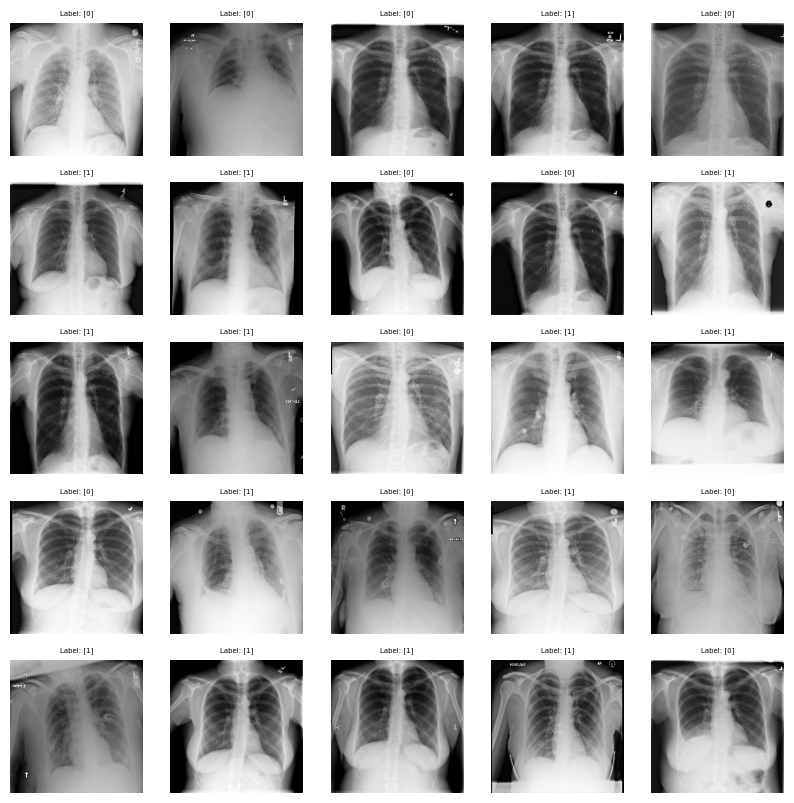

In [61]:
#Function to visualize images and their labels to make sure they were serialized and then parsed correctly:

def show_images_from_tfrecord(parsed_dataset, num_images=25):
    #Grid size tries to make a square of the images output:
    grid_size = math.ceil(math.sqrt(num_images))
    plt.figure(figsize=(10, 10))
    for i, parsed_record in enumerate(parsed_dataset.take(num_images)):
        image = parsed_record['image'].numpy()
        label = parsed_record['label'].numpy()

        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
        plt.title(f"Label: {label}", fontsize = 5)
        plt.axis('off')
    plt.show()


show_images_from_tfrecord(color_parsed_dataset)

In [78]:
#Splitting the parsed dataset into training, testing, and validation sets in a 70:15:15 ratio:

#Setting ratios:
total_size = count_examples(tfrecord_file)
train_size = int(0.14 * total_size)
test_size = int(0.03 * total_size)
val_size = int(0.03 * total_size)

#Splitting:
train_dataset = color_parsed_dataset.take(train_size) #Taking the first 70 percent of the total size to make the training dataset
test_dataset = color_parsed_dataset.skip(train_size).take(test_size)#Skipping over the first 70 percent of the total size, and then taking the next 15% to make the test dataset
val_dataset = color_parsed_dataset.skip(train_size + test_size).take(val_size)#Skipping over the first (70+15)=85% of the total size, and then taking the next 15% to make the validation dataset



In [103]:
#Setting up list of test dataset filepaths. Sample of test images will be copied
#to the deployment files for use in Flask web app:

test_filepaths = []

#Taking the row that represents 17% of the way through the rows of xray dataframe.
#Train, test, validation was set up in a 0.14:0.03:0.03 ratio using the take/skip
#tensor Flow methods (start from begining).
start = math.ceil(len(xray_info_df_undersampled)*0.17)
end = math.floor(len(xray_info_df_undersampled)*0.20)


for i in range(start, end):
    test_filepaths.append(xray_info_df_undersampled.iloc[i]['File path'])

##Take a sample fo the test_filepaths so the download is not too big:
test_filepaths_sample = random.sample(test_filepaths,20)

#Specify a download location inside the mounted Google Drive:
drive_path = '/content/drive/MyDrive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/test_images.zip'

# Ensure the directory exists
os.makedirs(os.path.dirname(drive_path), exist_ok=True)

# Create a ZIP file of the sampled test images:
with zipfile.ZipFile(drive_path, 'w') as zipf:
    for file in test_filepaths_sample:
        zipf.write(file)

In [67]:
#Take a look at the shape of things before data preprocessing:
for element in test_dataset.take(1):
  print(element)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03921569, 0.03921569, 0.03921569],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.12156863, 0.12156863, 0.12156863],
        [0.10980392, 0.10980392, 0.10980392]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412],
        ...,
        [0.02745098, 0.02745098, 0.02745098],
        [0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412]],

       [[0.03529412, 0.03529412, 0.03529412],
        [0.03529412, 0.03529412, 0.03529412],
        [0.04313726, 0.04313726, 0.04313726],
        ...,
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       ...,

       [[0.40784314, 0.40784314, 0.40784314],
        [0.4

In [65]:
#Preprocessing data:

def preprocess(example):
    # Convert image to float32 and normalize
    image = tf.cast(example['image'], tf.float32) / 255.0
    # Convert single-channel grayscale image to 3-channel if needed
    image = tf.image.grayscale_to_rgb(image) if image.shape[-1] == 1 else image
    # Flatten the label tensor to ensure it's of the shape (n_classes,)
    #label = tf.squeeze(example['label'])
    label = example['label']
    return image, label

# Apply the preprocessing function to the dataset
train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

In [ ]:
#Sequential model configured for the augmentation of the image data (will be used
#functionally to augment the training data set):

#-------------------------------------------------------------------------------
  #A note on augmentation of medical imagery:

  #I have chosen to restrict the augmentation of the images to only slight rotations
  #and mild scaling/zooming. Any distortion of the anatomical features that negatively
  #effect anatomical accuracy should be avoided, as deviating from the human form,
  #or from the standards and guidelines for making and interpreting medical images,
  #will result in images that do not reflect real-world scenarios.
  #Input from medical professionals would be essential in determining the appropriatness
  #of theses and other augmentations.
#-------------------------------------------------------------------------------

data_augmentation = tf.keras.Sequential([

    # Mild rotation:
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.015),

    #Mild height shift:
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.05),

    #Mild width shift:
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.1),

    # Mild zoom:
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15, 0.15, fill_mode='reflect'),

    # Mild contrast adjustment:
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),

    # Horizontal flipping:
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),

    #Resize to be (224x224):
    tf.keras.layers.experimental.preprocessing.Resizing(224, 224)
])




In [ ]:
type(train_dataset)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
#Apply data augmentation to training set (exclusively). Note: Data Augmentation here include resizing and normalization (see cell above):

train_dataset = train_dataset.map(
    lambda image, label: (data_augmentation(image, training=True), label)
)




In [69]:
#Mapping the datasets to return only the tensors, not the dictionary:
# train_dataset_tensors = train_dataset.map(lambda features: (features['image'],features['label']))
# test_dataset_tensors = test_dataset.map(lambda features: (features['image'],features['label']))
# val_dataset_tensors = val_dataset.map(lambda features: (features['image'],features['label']))

#Batching the dataset in preparation for TensorFlow neural network:
batch_size = 32
buffer_size = 1000
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [54]:
#Checking for shape of images going into the CNN (should be (batch_size, 224,224,3)):
# Take one batch from the dataset
for images, labels in train_dataset.take(1):
    # images and labels are now tensors representing a batch of your dataset
    print(images.shape)  # This prints the shape of the features (e.g., (batch_size, height, width, channels)) Expecting(batch_size, 224,224,3)
    print(labels.shape)  # This prints the shape of the labels (e.g., (batch_size, num_classes)) Expecting (batch_size,) for binary classification.



(224, 224, 3)
(1,)


# CNN Architechture(s)

In [ ]:
#VGG16-like CNN Architechture:



# #Instantiating a Sequential model:
# model = tf.keras.Sequential()

# #CONVOLUTION LAYERS:

# # Two convolutional layers with 64 filters, kernal size of 3x3, with a Max pooling layer:
# model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1))) #Conv1
# model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')) #Conv2
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# # Two convolutional layers with 128 filters, kernal size of 3x3, with a Max pooling layer:
# model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')) #Conv3
# model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')) #Conv4
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# # Three convolutional layers with 256 filters, kernal size of 3x3, with a Max pooling layer:
# model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')) #Conv5
# model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')) #Conv6
# model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')) #Conv7
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# # Three convolutional layers with 512 filters, kernal size of 3x3, with a Max pooling layer:
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv8
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv9
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv10
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# #Three convolutional layers with 512 filters, kernal size of 3x3, with a Max pooling layer for downsampling:
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv11
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv12
# model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')) #Conv13
# model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# #DENSE (FULLY CONNECTED) LAYERS:

# #Two fully connected layers, accepting 4096 units with ReLU activation:
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(4096, activation='relu'))
# model.add(tf.keras.layers.Dense(4096, activation='relu'))

# #Output classification layer (for training of the CNN):
# model.add(tf.keras.layers.Dense(15, activation = 'sigmoid'))

# #Compile the model using binary_crossentropy as loss function due to the binary nature of the classification:
# model.compile(
#     optimizer = 'adam',
#     loss='binary_crossentropy',
#     metrics = ['accuracy']
# )
# model.summary()

In [ ]:
## CNN Architecture inspired by K Scott Mader's "Train Simple XRay CNN" notebook
# Source: https://www.kaggle.com/code/kmader/train-simple-xray-cnn
# This architecture was adapted from the aforementioned source and modified to fit the specific needs of our project.
# The original notebook provided a foundational understanding and structure for building CNN models for X-ray image analysis.

base_mobilenet_model = MobileNet(input_shape =  (224,224,3),
                                 include_top = False, weights = 'imagenet')
binary_disease_model = Sequential()
binary_disease_model.add(base_mobilenet_model)
binary_disease_model.add(GlobalAveragePooling2D())
binary_disease_model.add(Dropout(0.5))
binary_disease_model.add(Dense(512))
binary_disease_model.add(Dropout(0.5))
binary_disease_model.add(Dense(1, activation = 'sigmoid'))
binary_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
binary_disease_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
#Setting up early stopping to avoid overfitting:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

In [ ]:
# Define the checkpoint callback to save the model whenever the val_loss improves:
checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/binary_mobilnet_transferlearn_checkpoint.h5',  # Save the model to this file
    save_best_only=True,             # Only save a model if 'val_loss' has improved
    monitor='val_loss',              # Monitor 'val_loss' for improvement
    verbose=1                        # Log when a new checkpoint is saved
)

In [ ]:
#Train the chosen model:

history = binary_disease_model.fit(train_dataset,
                                  validation_data=val_dataset,
                                  epochs=100,
                                  callbacks=[early_stopping, checkpoint_cb])

Epoch 1/100
    271/Unknown - 125s 339ms/step - loss: 0.9427 - binary_accuracy: 0.5596 - mae: 0.4720
Epoch 1: val_loss improved from inf to 0.72115, saving model to /content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/binary_mobilnet_transferlearn_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


271/271 [==============================] - 129s 355ms/step - loss: 0.9427 - binary_accuracy: 0.5596 - mae: 0.4720 - val_loss: 0.7212 - val_binary_accuracy: 0.6053 - val_mae: 0.4505
Epoch 2/100
270/271 [============================>.] - ETA: 0s - loss: 0.6758 - binary_accuracy: 0.5919 - mae: 0.4632
Epoch 2: val_loss did not improve from 0.72115
271/271 [==============================] - 106s 348ms/step - loss: 0.6757 - binary_accuracy: 0.5922 - mae: 0.4632 - val_loss: 0.7495 - val_binary_accuracy: 0.5240 - val_mae: 0.4676
Epoch 3/100
270/271 [============================>.] - ETA: 0s - loss: 0.6705 - binary_accuracy: 0.6028 - mae: 0.4605
Epoch 3: val_loss did not improve from 0.72115
271/271 [==============================] - 105s 347ms/step - loss: 0.6708 - binary_accuracy: 0.6023 - mae: 0.4607 - val_loss: 0.7257 - val_binary_accuracy: 0.5326 - val_mae: 0.4663
Epoch 4/100
270/271 [============================>.] - ETA: 0s - loss: 0.6615 - binary_accuracy: 0.6115 - mae: 0.4574
Epoch 4: 

KeyboardInterrupt: ignored

In [24]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Concordia Bootcamp - Chest X-Ray diagnosis tool/Data/Binary_model_data/binary_mobilnet_transferlearn_checkpoint.h5')

In [70]:
#Make predictions on the test set using the now trained model:
test_predictions = model.predict(test_dataset)

59/59 [==============================] - 24s 358ms/step


In [71]:
#Convert output probabilities to binary predictions:
treshold = 0.5
test_predictions_binary = (test_predictions > treshold).astype(int)

1/1 [==============================] - 0s 36ms/step


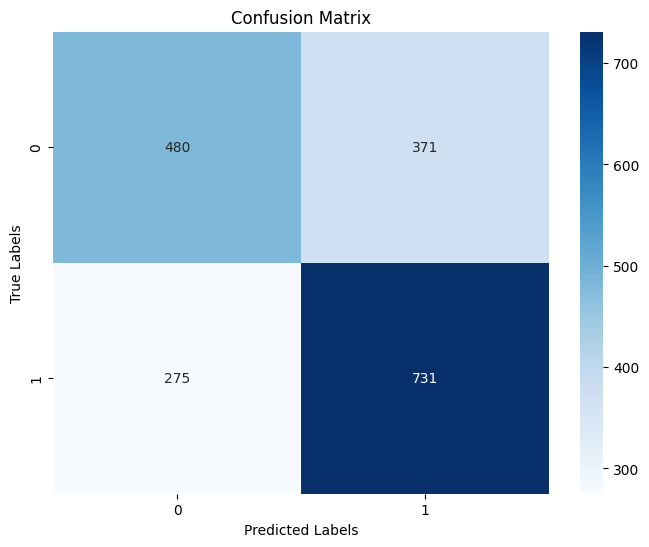

Accuracy: 0.652
Precision: 0.663
Recall: 0.727
F1: 0.684


In [76]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the metric objects
accuracy_metric = tf.metrics.BinaryAccuracy(threshold=0.5)
precision_metric = tf.metrics.Precision()
recall_metric = tf.metrics.Recall()
f1_metric = tf.keras.metrics.Mean()  # For F1, we'll calculate it manually

# Initialize lists for true labels and predictions
true_labels = []
predictions = []

# Iterate over the test dataset
for images, labels in test_dataset:
    # Generate predictions
    preds = model.predict(images)
    preds_binary = (preds > 0.5).astype(int)

    # Update the metrics
    accuracy_metric.update_state(labels, preds_binary)
    precision_metric.update_state(labels, preds_binary)
    recall_metric.update_state(labels, preds_binary)

    # Calculate F1 score and update the mean F1 metric
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    f1_metric.update_state(f1_score)

    # Store true labels and predictions for confusion matrix
    true_labels.extend(labels.numpy())
    predictions.extend(preds_binary)

# Compute the final metrics
final_accuracy = accuracy_metric.result().numpy()
final_precision = precision_metric.result().numpy()
final_recall = recall_metric.result().numpy()
final_f1 = f1_metric.result().numpy()

# Convert lists to numpy arrays and ensure they are 1D
true_labels = np.array(true_labels).flatten()
predictions = np.array(predictions).flatten()

# Create the confusion matrix
conf_matrix = tf.math.confusion_matrix(true_labels, predictions)

# Convert to numpy array for easy plotting
conf_matrix_np = conf_matrix.numpy()

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_np, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the performance metrics
print('Accuracy: %.3f' % final_accuracy)
print('Precision: %.3f' % final_precision)
print('Recall: %.3f' % final_recall)
print('F1: %.3f' % final_f1)


In [77]:
xray_info_df_undersampled[]

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,File path,healthy
0,108219,00029299_000.png,No Finding,0,29299,58,M,PA,2021,2021,0.194311,0.194311,NaN,/content/drive/My Drive/Colab Notebooks/Concor...,[1]
